### Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week08_autoencoders/lfw_dataset.py -O lfw_dataset.py
!pip install Image Pillow==5.1.0 scipy==1.1.0
!pip install scikit-learn==0.20.0

import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cpu") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

--2021-03-20 10:45:31--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week08_autoencoders/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3060 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.99K  --.-KB/s    in 0s      

2021-03-20 10:45:31 (49.9 MB/s) - ‘lfw_dataset.py’ saved [3060/3060]

cpu


In [2]:
BATCH_SIZE = 32

In [3]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

In [5]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [6]:
img_shape

(3, 38, 38)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


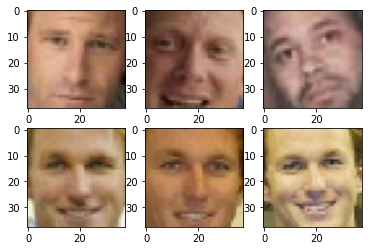

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [8]:
# this class corresponds to view-function and may be used as a reshape layer 

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [9]:
class pca_autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=32):
        super(pca_autoencoder, self).__init__()
        self.enc = nn.Sequential(View(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), View(-1, img_shape[0], img_shape[1], img_shape[2])) 

    def code(self, batch):
        return self.enc(batch)
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction)**2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [10]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [11]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].to(device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [12]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:02, 127.42it/s]
14it [00:00, 131.51it/s]

1, Train loss: 0.14541177270087674, Test loss: 0.03091150145480151


370it [00:02, 128.46it/s]
14it [00:00, 130.06it/s]

2, Train loss: 0.02527027076270169, Test loss: 0.023742308783625037


370it [00:02, 125.56it/s]
13it [00:00, 125.94it/s]

3, Train loss: 0.023196606286458376, Test loss: 0.02323581716204369


236it [00:01, 126.28it/s]


KeyboardInterrupt: ignored

In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.007439585343734885


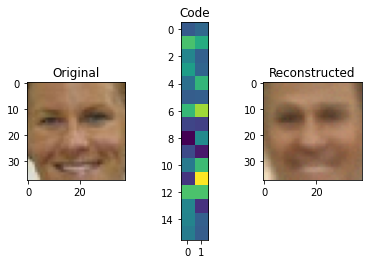

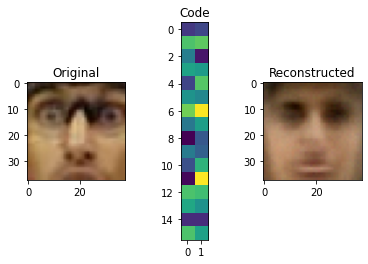

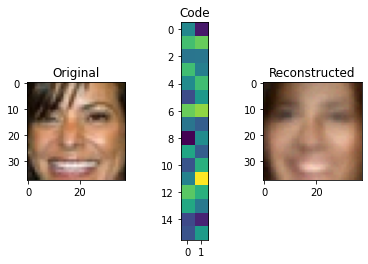

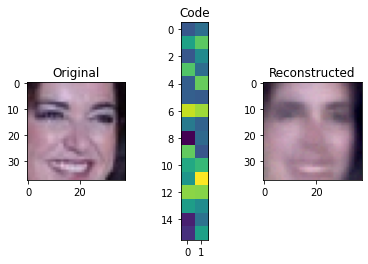

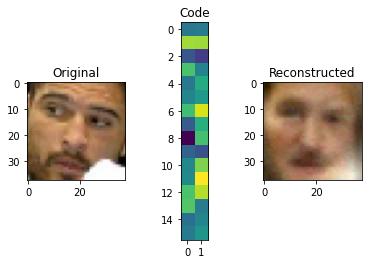

In [ ]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [ ]:
class pca_autoencoder_deep(nn.Module):
    def __init__(self, code_size=32):
        super(pca_autoencoder_deep, self).__init__()
        img_prod = np.prod(img_shape);
        self.enc = nn.Sequential(View(-1, np.prod(img_shape)),
                                 nn.Linear(img_prod, img_prod//2),
                                 nn.ReLU(),
                                 nn.Linear(img_prod//2, img_prod//4),
                                 nn.BatchNorm1d(num_features=img_prod//4),
                                 nn.Linear(img_prod//4, code_size))
        
        self.dec = nn.Sequential(nn.Linear(code_size, img_prod//4),
                                 nn.Linear(img_prod//4, img_prod//2),
                                 nn.ReLU(),
                                 nn.Linear(img_prod//2, img_prod),
                                 View(-1, img_shape[0], img_shape[1], img_shape[2]))
        
    def code(self, batch):
      re
    
    turn self.enc(batch)
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [ ]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = pca_autoencoder_deep(code_size).double().to(device)
    encoder_out = model.enc(help_tensor.to(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:]==torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:]==img_shape,   "decoder must output an image of valid shape"

    #assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [ ]:
aenc_deep = pca_autoencoder_deep()
train(aenc_deep, X_train_tensor, X_test_tensor, 50)

370it [04:42,  1.31it/s]
0it [00:00, ?it/s]

1, Train loss: 0.025285171235809506, Test loss: 0.012951814376712511


370it [04:43,  1.30it/s]
0it [00:00, ?it/s]

2, Train loss: 0.012338330809579549, Test loss: 0.011749054008148484


370it [04:43,  1.31it/s]
0it [00:00, ?it/s]

3, Train loss: 0.011181275102879374, Test loss: 0.012378951639804505


370it [04:43,  1.31it/s]
0it [00:00, ?it/s]

4, Train loss: 0.0103571977209766, Test loss: 0.011832707639853338


370it [04:44,  1.30it/s]
0it [00:00, ?it/s]

5, Train loss: 0.009769742346267514, Test loss: 0.009954532505563983


370it [04:40,  1.32it/s]
0it [00:00, ?it/s]

6, Train loss: 0.009268083120658653, Test loss: 0.00950220041313456


370it [04:39,  1.32it/s]
0it [00:00, ?it/s]

7, Train loss: 0.009296597361886446, Test loss: 0.011150513796511797


370it [04:39,  1.32it/s]
0it [00:00, ?it/s]

8, Train loss: 0.009225131638008269, Test loss: 0.009276589162695768


370it [04:39,  1.32it/s]
0it [00:00, ?it/s]

9, Train loss: 0.008892329295824423, Test loss: 0.009133230358571448


370it [04:39,  1.32it/s]
0it [00:00, ?it/s]

10, Train loss: 0.008670709777230569, Test loss: 0.010520158156351716


370it [04:40,  1.32it/s]
0it [00:00, ?it/s]

11, Train loss: 0.008689515421851741, Test loss: 0.01014858283045771


370it [04:40,  1.32it/s]
0it [00:00, ?it/s]

12, Train loss: 0.008649201276179935, Test loss: 0.00884388706526306


370it [04:40,  1.32it/s]
0it [00:00, ?it/s]

13, Train loss: 0.008475040725707426, Test loss: 0.011015754395948749


370it [04:40,  1.32it/s]
0it [00:00, ?it/s]

14, Train loss: 0.008372348909124553, Test loss: 0.00957867344573067


370it [04:40,  1.32it/s]
0it [00:00, ?it/s]

15, Train loss: 0.008287225163754934, Test loss: 0.010336453787308431


370it [04:39,  1.32it/s]
0it [00:00, ?it/s]

16, Train loss: 0.00810547678401018, Test loss: 0.008718991197622646


370it [04:38,  1.33it/s]
0it [00:00, ?it/s]

17, Train loss: 0.00797606601497629, Test loss: 0.008720708873573142


370it [05:12,  1.18it/s]
0it [00:00, ?it/s]

18, Train loss: 0.00795390039476239, Test loss: 0.008477981271293211


370it [06:30,  1.05s/it]
0it [00:00, ?it/s]

19, Train loss: 0.007741731238707229, Test loss: 0.008501733936215112


370it [05:56,  1.04it/s]
0it [00:00, ?it/s]

20, Train loss: 0.007750510657287425, Test loss: 0.008412922886003496


370it [05:56,  1.04it/s]
0it [00:00, ?it/s]

21, Train loss: 0.007560366817249803, Test loss: 0.008314350266127585


370it [05:57,  1.04it/s]
0it [00:00, ?it/s]

22, Train loss: 0.007411423694740535, Test loss: 0.007861847086186615


370it [05:54,  1.04it/s]
0it [00:00, ?it/s]

23, Train loss: 0.007336260165585483, Test loss: 0.00771998784273912


370it [05:57,  1.04it/s]
0it [00:00, ?it/s]

24, Train loss: 0.007292037517115215, Test loss: 0.007571225369791427


370it [05:59,  1.03it/s]
0it [00:00, ?it/s]

25, Train loss: 0.0072940118884002175, Test loss: 0.008668662301390821


370it [06:00,  1.03it/s]
0it [00:00, ?it/s]

26, Train loss: 0.007152567473097871, Test loss: 0.008514364501965686


370it [06:00,  1.03it/s]
0it [00:00, ?it/s]

27, Train loss: 0.007032490332958891, Test loss: 0.008027497650009832


370it [06:01,  1.02it/s]
0it [00:00, ?it/s]

28, Train loss: 0.00701630964034302, Test loss: 0.007839340383449142


370it [06:01,  1.02it/s]
0it [00:00, ?it/s]

29, Train loss: 0.006946833060761585, Test loss: 0.008007447608836883


370it [06:01,  1.02it/s]
0it [00:00, ?it/s]

30, Train loss: 0.0068723435599618715, Test loss: 0.007738136232004746


370it [05:59,  1.03it/s]
0it [00:00, ?it/s]

31, Train loss: 0.0068990755919201415, Test loss: 0.0079161004311239


370it [06:06,  1.01it/s]
0it [00:00, ?it/s]

32, Train loss: 0.006828362597114461, Test loss: 0.007689022107936357


370it [06:08,  1.00it/s]
0it [00:00, ?it/s]

33, Train loss: 0.006683409102689792, Test loss: 0.008032786927387285


370it [06:11,  1.00s/it]
0it [00:00, ?it/s]

34, Train loss: 0.006701043722416503, Test loss: 0.007784404814680594


370it [06:12,  1.01s/it]
0it [00:00, ?it/s]

35, Train loss: 0.006609621975064943, Test loss: 0.007902509222887657


370it [06:12,  1.01s/it]
0it [00:00, ?it/s]

36, Train loss: 0.006647367273010145, Test loss: 0.007647719573648298


370it [06:12,  1.01s/it]
0it [00:00, ?it/s]

37, Train loss: 0.006497692493557046, Test loss: 0.00768595878891281


370it [06:17,  1.02s/it]
0it [00:00, ?it/s]

38, Train loss: 0.0065076046842096995, Test loss: 0.008039179365494756


370it [06:22,  1.03s/it]
0it [00:00, ?it/s]

39, Train loss: 0.006498845999563266, Test loss: 0.007849285161400186


370it [06:26,  1.04s/it]
0it [00:00, ?it/s]

40, Train loss: 0.006469670762336409, Test loss: 0.007651849080108876


370it [06:26,  1.04s/it]
0it [00:00, ?it/s]

41, Train loss: 0.0064404979059391205, Test loss: 0.007798832315603825


370it [06:23,  1.04s/it]
0it [00:00, ?it/s]

42, Train loss: 0.006393850916380752, Test loss: 0.007701868904363083


370it [06:26,  1.05s/it]
0it [00:00, ?it/s]

43, Train loss: 0.006389789078966033, Test loss: 0.007586808724656978


370it [06:26,  1.04s/it]
0it [00:00, ?it/s]

44, Train loss: 0.0062738810764268165, Test loss: 0.008244732189643604


164it [02:49,  1.04s/it]

KeyboardInterrupt: ignored

Training may take long, it's okay.

0.007790205932122495
Final MSE: 0.007790205932122495


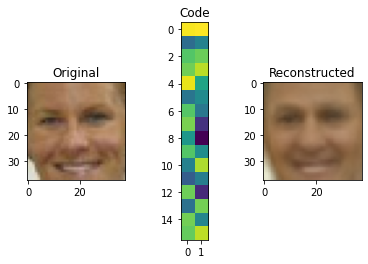

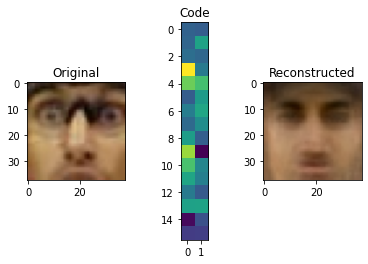

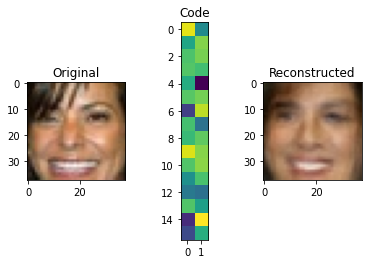

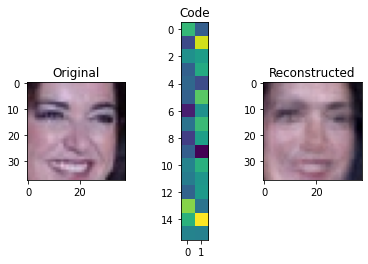

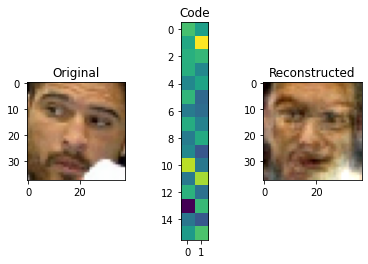

In [ ]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)
print(reconstruction_mse)
#assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape)==2 and encoder_out.shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [14]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """

    noise = np.random.normal(0, sigma, X.shape)
        
    return X + noise
    

In [14]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]),sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]),sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

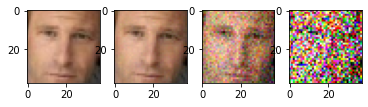

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]),sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]),sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]),sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [15]:
aenc = pca_autoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:05, 72.26it/s]
8it [00:00, 71.67it/s]

1, Train loss: 0.14452320077795947, Test loss: 0.03073660522244706


370it [00:05, 71.07it/s]
8it [00:00, 74.08it/s]

2, Train loss: 0.026260783892741203, Test loss: 0.02403524865108345


370it [00:05, 69.71it/s]
7it [00:00, 63.72it/s]

3, Train loss: 0.024246803845517254, Test loss: 0.02327588408099071


370it [00:05, 68.81it/s]
7it [00:00, 64.43it/s]

4, Train loss: 0.023974357126188964, Test loss: 0.023078451754660396


370it [00:05, 66.99it/s]
8it [00:00, 70.34it/s]

5, Train loss: 0.023767135785432124, Test loss: 0.022729769766260163


370it [00:05, 70.31it/s]
7it [00:00, 62.48it/s]

6, Train loss: 0.02348452616148662, Test loss: 0.022615599963665935


370it [00:05, 67.65it/s]
7it [00:00, 67.92it/s]

7, Train loss: 0.023074683952148758, Test loss: 0.022171213545079543


370it [00:05, 66.55it/s]
7it [00:00, 64.52it/s]

8, Train loss: 0.022293710904458645, Test loss: 0.021457839707754767


370it [00:05, 66.56it/s]
8it [00:00, 71.06it/s]

9, Train loss: 0.021187502373237254, Test loss: 0.02037277803348905


370it [00:05, 68.52it/s]
7it [00:00, 67.59it/s]

10, Train loss: 0.01940766111827083, Test loss: 0.018398521366724548


370it [00:05, 66.57it/s]
7it [00:00, 65.02it/s]

11, Train loss: 0.01755519968422434, Test loss: 0.01664498605790938


370it [00:05, 69.33it/s]
7it [00:00, 66.47it/s]

12, Train loss: 0.015892634627028418, Test loss: 0.014659329524923978


370it [00:05, 69.98it/s]
8it [00:00, 72.16it/s]

13, Train loss: 0.01455293543968915, Test loss: 0.01415661507360457


370it [00:05, 69.92it/s]
8it [00:00, 73.03it/s]

14, Train loss: 0.013477554296028713, Test loss: 0.012779540527387405


370it [00:05, 69.65it/s]
7it [00:00, 64.97it/s]

15, Train loss: 0.012437217619091688, Test loss: 0.011946794861937308


370it [00:05, 68.86it/s]
8it [00:00, 72.78it/s]

16, Train loss: 0.011724424799063807, Test loss: 0.011516325989529988


370it [00:05, 70.62it/s]
8it [00:00, 71.72it/s]

17, Train loss: 0.01115984466807064, Test loss: 0.010910110589858784


370it [00:05, 69.52it/s]
7it [00:00, 69.76it/s]

18, Train loss: 0.010641198735289924, Test loss: 0.01092122228226521


370it [00:05, 69.66it/s]
7it [00:00, 69.30it/s]

19, Train loss: 0.010244768486476506, Test loss: 0.01000480684770069


370it [00:05, 69.39it/s]
7it [00:00, 67.37it/s]

20, Train loss: 0.009905104326579608, Test loss: 0.009765542640013756


370it [00:05, 70.16it/s]
7it [00:00, 66.32it/s]

21, Train loss: 0.009557060586789309, Test loss: 0.009200352184142462


370it [00:05, 71.09it/s]
7it [00:00, 69.16it/s]

22, Train loss: 0.00933611106181674, Test loss: 0.00943001927279144


370it [00:05, 71.37it/s]
8it [00:00, 72.87it/s]

23, Train loss: 0.00910254409332251, Test loss: 0.008954731589289605


370it [00:05, 71.17it/s]
7it [00:00, 69.99it/s]

24, Train loss: 0.00888725356622662, Test loss: 0.008930427033336246


370it [00:05, 71.18it/s]
7it [00:00, 69.53it/s]

25, Train loss: 0.008685913236663154, Test loss: 0.008946163223194716


370it [00:05, 70.35it/s]
8it [00:00, 72.44it/s]

26, Train loss: 0.008450003200312148, Test loss: 0.008428027911318794


370it [00:05, 71.48it/s]
8it [00:00, 75.10it/s]

27, Train loss: 0.008318449117883039, Test loss: 0.009097654432116733


370it [00:05, 73.00it/s]
8it [00:00, 71.74it/s]

28, Train loss: 0.008179885369527176, Test loss: 0.008301200487594636


370it [00:05, 71.96it/s]
8it [00:00, 71.31it/s]

29, Train loss: 0.008070903310252177, Test loss: 0.008023562799515832


370it [00:05, 69.58it/s]
7it [00:00, 69.37it/s]

30, Train loss: 0.007900444363784452, Test loss: 0.008172945248663526


370it [00:05, 66.83it/s]
7it [00:00, 69.13it/s]

31, Train loss: 0.007855189306180146, Test loss: 0.007792730271840922


370it [00:05, 67.57it/s]
7it [00:00, 66.52it/s]

32, Train loss: 0.0078008872112886925, Test loss: 0.007901250504247686


370it [00:05, 68.19it/s]
8it [00:00, 71.94it/s]

33, Train loss: 0.007746886025229162, Test loss: 0.007551622675578752


370it [00:05, 68.89it/s]
7it [00:00, 67.48it/s]

34, Train loss: 0.007628191353211355, Test loss: 0.007793626575832347


370it [00:05, 67.18it/s]
7it [00:00, 62.96it/s]

35, Train loss: 0.007622119992983401, Test loss: 0.007670463087693147


370it [00:05, 66.86it/s]
7it [00:00, 65.98it/s]

36, Train loss: 0.00759040393666396, Test loss: 0.007557655030586101


370it [00:05, 68.48it/s]
7it [00:00, 69.59it/s]

37, Train loss: 0.007525453167501024, Test loss: 0.007533671402896643


370it [00:05, 68.20it/s]
8it [00:00, 71.45it/s]

38, Train loss: 0.007516270976082906, Test loss: 0.0075315416840451765


370it [00:05, 68.38it/s]
8it [00:00, 73.45it/s]

39, Train loss: 0.007505836236512685, Test loss: 0.007422241509602293


370it [00:05, 70.50it/s]
7it [00:00, 69.99it/s]

40, Train loss: 0.0074631534036219615, Test loss: 0.0073597417087328905


370it [00:05, 70.50it/s]
8it [00:00, 71.94it/s]

41, Train loss: 0.007416243922174189, Test loss: 0.007538479251038887


370it [00:05, 69.27it/s]
8it [00:00, 71.00it/s]

42, Train loss: 0.007397092796038961, Test loss: 0.007329671673507412


370it [00:05, 69.53it/s]
7it [00:00, 67.39it/s]

43, Train loss: 0.007400296850096311, Test loss: 0.007304963586559576


370it [00:05, 68.27it/s]
8it [00:00, 71.12it/s]

44, Train loss: 0.00732583746243804, Test loss: 0.007280680565403854


370it [00:05, 69.44it/s]
7it [00:00, 68.45it/s]

45, Train loss: 0.007345059003376828, Test loss: 0.007383131160639293


370it [00:05, 67.17it/s]
7it [00:00, 67.76it/s]

46, Train loss: 0.007371474202818523, Test loss: 0.007315193466463996


370it [00:05, 66.97it/s]
7it [00:00, 68.86it/s]

47, Train loss: 0.007258302343230536, Test loss: 0.007303379345632928


370it [00:05, 68.75it/s]
7it [00:00, 66.82it/s]

48, Train loss: 0.007297606038213867, Test loss: 0.007355934455195294


370it [00:05, 69.06it/s]
7it [00:00, 64.08it/s]

49, Train loss: 0.007313451954833007, Test loss: 0.007242548534935483


370it [00:05, 69.58it/s]


50, Train loss: 0.007255814356560079, Test loss: 0.007360511992821075


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.007381075623477789


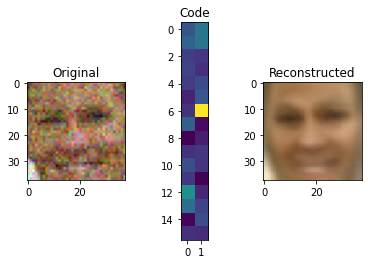

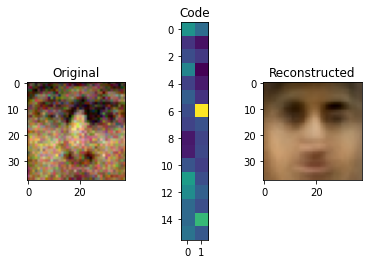

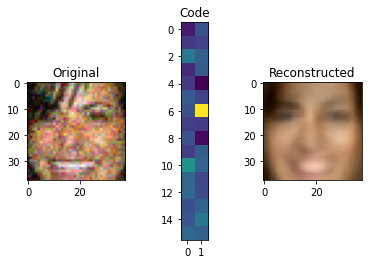

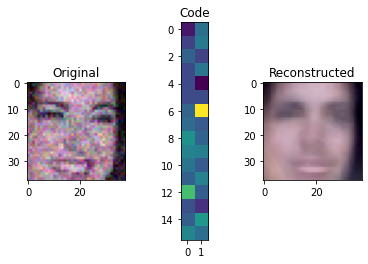

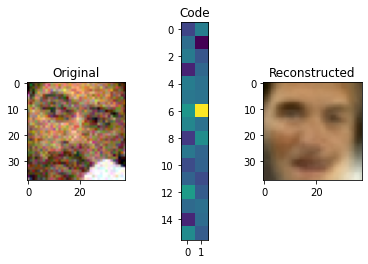

In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.to(device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [17]:
#encodes batch of images into a codes
codes = aenc.code(X_train_tensor)
codes


tensor([[ 0.6287,  0.9778,  0.2380,  ..., -0.0303, -1.8987, -2.1441],
        [ 0.5706,  0.4318,  0.0068,  ..., -0.3170, -1.6973, -2.6953],
        [ 1.1730,  0.0984, -0.0362,  ..., -0.1670, -2.6074, -2.5148],
        ...,
        [ 0.5873, -0.5045,  0.0362,  ...,  0.3309, -1.7422, -2.5648],
        [ 0.9534,  1.0063, -0.1385,  ..., -0.1028, -1.5846, -2.0939],
        [ 0.6391, -0.1912,  0.9558,  ..., -0.6170, -1.1772, -1.7088]],
       dtype=torch.float64, grad_fn=<AddmmBackward>)

In [18]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [19]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [32]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [33]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape)==3,"image must be [batch,height,width,3]"

    code = aenc.enc(image.cuda().to(device)).detach().numpy()
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [34]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

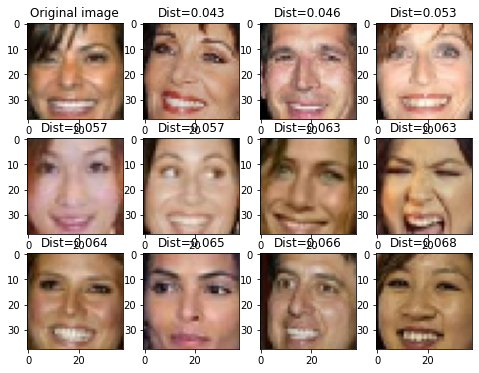

In [35]:
#smiles
show_similar(X_test_tensor[2])

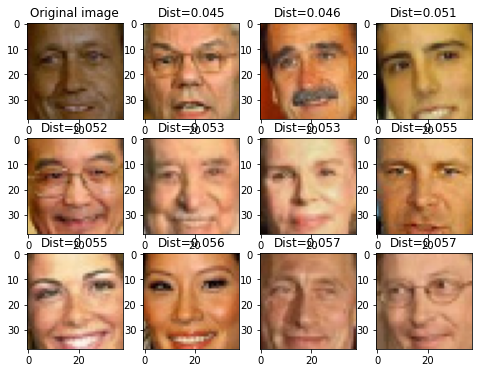

In [36]:
#ethnicity
show_similar(X_test_tensor[500])

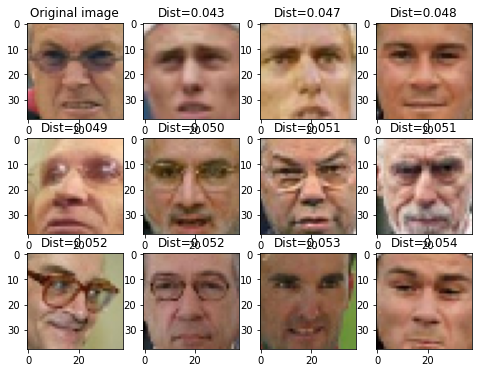

In [37]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


In [ ]:
image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]
a = np.stack([image1,image2])
a.shape

(2, 38, 38, 3)

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


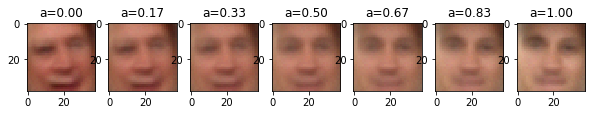

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


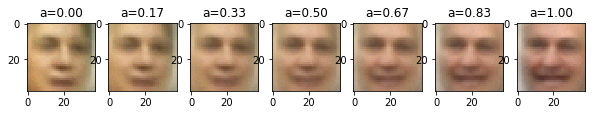

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


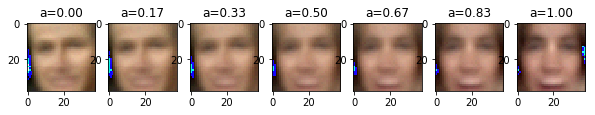

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


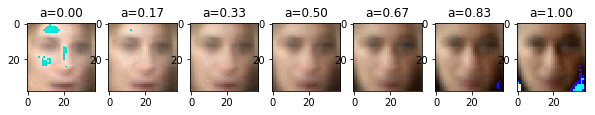

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


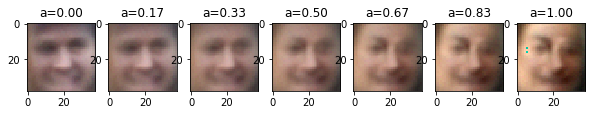

In [ ]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = aenc.enc(torch.cat((image1,image2), 0).cuda(device))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy())
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.